## NLP Midterm Assignment

In [1]:
import spacy
import os
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

### 1.1 Introduction

### 1.2 Data Preprocessing

In [61]:
df = pd.read_csv('datasets/guardian_dataset_cleaned.csv', index_col=[0])
df = df.dropna()

In [5]:
df.head()

,headline,body,date
0,The sure way to end the war,Mr Winston Churchill at the London Opera House...,1914-09-12
1,The Election and After,The election which takes place to-day will dec...,1918-12-14
2,Italy in Fascist control,"At the moment when Mussolini, the leader of th...",1922-10-30
3,Bavarian monarchist rising broken,The German reactionaries have struck and faile...,1923-11-10
4,Emergency regulations,"The first day of the strike passed off, in a s...",1926-05-06


In [62]:
df.describe()

,headline,body,date
count,22657,22657,22657
unique,21254,22577,6926
top,Diary,The undeclared race to succeed Paddy Ashdown a...,2005-04-04
freq,567,3,173


In [21]:
df2 = df.copy()
df2['year'] = pd.DatetimeIndex(df2['date']).year

In [36]:
df2['decade'] = df2['year'] - df2['year']%10

In [22]:
df2.groupby(['year']).count()

,headline,body,date
year,,,
1914,1,1,1
1918,1,1,1
1922,1,1,1
1923,1,1,1
1926,1,1,1
...,...,...,...
2018,645,645,645
2019,834,834,834
2020,278,278,278


<Figure size 432x288 with 0 Axes>

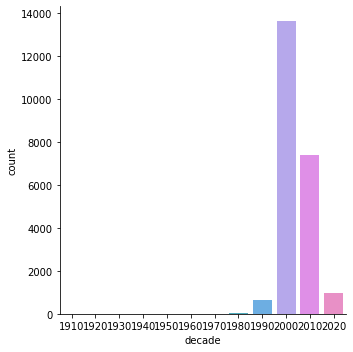

In [37]:
plt.pyplot.figure()
sns.catplot(x='decade', kind='count', data=df2)

In [51]:
df2[df2['year'] < 1990]

51

In [15]:
len(list(df['headline']))

22687

In [66]:
document_headlines = df['headline'].to_list()
document_body = df['body'].to_list()

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22657 entries, 0 to 22686
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  22657 non-null  object
 1   body      22657 non-null  object
 2   date      22657 non-null  object
dtypes: object(3)
memory usage: 708.0+ KB


In [41]:
nlp = spacy.load('en_core_web_sm')

In [70]:
raw_docs = [[token.text for token in nlp(doc, disable = ['parser', 'ner'])] for doc in document_headlines]

In [71]:
docs_body_token = [[token.text for token in nlp(doc, disable = ['parser', 'ner'])] 
                    for doc in document_body]

In [75]:
docs_body_preprocess = [[token.lemma_ for token in nlp(doc, disable = ['parser', 'ner'])
                    if token.is_alpha
                    and not token.is_stop
                    and len(token.text) > 2]
                    for doc in document_body]

In [79]:
df['body_token'] = docs_body_token
df['body_pproc'] = docs_body_preprocess

In [82]:
# df.to_csv('guardian_data_pprocessed.csv')

In [89]:
token_count_raw = sum([len(doc) for doc in docs_body_token])
token_count_preprocessed = sum([len(doc) for doc in docs_body_preprocess])
types_count_raw = len(set([w for doc in docs_body_token for w in doc]))
types_count_preprocessed = len(set([w for doc in docs_body_preprocess for w in doc]))

In [92]:
pd.DataFrame([[token_count_raw, types_count_raw], [token_count_preprocessed,types_count_preprocessed]],
            columns = ['Tokens', 'Types'], index=['Raw', 'Pre-processed'])

,Tokens,Types
Raw,35347120,154064
Pre-processed,14347614,109985


In [66]:
df = pd.read_csv('datasets/guardian_data_pprocessed.csv', index_col=[0])

In [69]:
df = df.dropna().reset_index(drop=True)

In [57]:
data_pproc = df['body_pproc']
data_pproc.reset_index(drop = True, inplace=True)

data_raw = df['body_token']
data_raw.reset_index(drop = True, inplace=True)

In [58]:
for i in range(len(data_pproc)):
    try:
        data_pproc[i] = data_pproc[i][1:-1].replace("'", '').split(', ')
    except Exception:
        continue

In [59]:
for i in range(len(data_raw)):
    try:
        data_raw[i] = data_raw[i][1:-1].replace("'", '').split(', ')
    except Exception:
        continue

In [70]:
df['data_raw'] = data_raw

In [83]:
df['body_token'] = data_raw

In [84]:
df['body_pproc'] = data_pproc

In [89]:
df = df.iloc[:,:-1]

In [93]:
# df.to_pickle('guardian_dataset_pickle.p')

In [2]:
df = pd.read_pickle('datasets/guardian_dataset_pickle.p')

In [5]:
data_pproc = df['body_pproc']

In [6]:
del df

### Word2Vec

In [6]:
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.word2vec import FAST_VERSION

In [77]:
w2v = Word2Vec(vector_size=100, # vector size
               window=20, # window for sampling
               sample=0.001, # subsampling rate
               epochs=200, # iterations
               negative=5, # negative samples
               min_count=10, # minimum threshold
               workers=-1, # parallelize to all cores
               hs=0, # no hierarchical softmax
               seed=0)
w2v.build_vocab(data_pproc)
w2v.train(data_pproc, total_examples=w2v.corpus_count, epochs=w2v.epochs)

(0, 0)

In [101]:
w2v.wv.most_similar(['Iraq'])

[('death', 0.3891639709472656),
 ('euroland', 0.38123318552970886),
 ('toehold', 0.3811361789703369),
 ('Lennon', 0.34585633873939514),
 ('lapel', 0.3437573313713074),
 ('downhill', 0.34325793385505676),
 ('footed', 0.3336268663406372),
 ('misperception', 0.33294588327407837),
 ('Maryland', 0.3325503170490265),
 ('inscribe', 0.3312946856021881)]

In [104]:
w2v.wv.most_similar(['Iran'])

[('flexibly', 0.4174644351005554),
 ('Deborah', 0.4041740298271179),
 ('school', 0.3753429651260376),
 ('immune', 0.3740305006504059),
 ('subside', 0.373502254486084),
 ('decouple', 0.36919644474983215),
 ('Plant', 0.3605331778526306),
 ('Norwood', 0.3571367561817169),
 ('famed', 0.356245219707489),
 ('Abuses', 0.35018983483314514)]

### Doc2Vec

In [185]:
df['tags'] = np.empty((len(df), 0)).tolist()

In [196]:
df[(df['date'] >= '2022') & (df['body'].str.contains('Ukraine'))]['tags']\
    .apply(lambda x: x.append('Ukraine'))

df[(df['date'] <= '2009' ) & (df['date'] >= '2003') & (df['body'].str.contains('Iraq'))]['tags']\
    .apply(lambda x: x.append('Iraq'))

df[(df['date'] <= '2022' ) & (df['date'] >= '2001') & (df['body'].str.contains('Afghanistan'))]['tags']\
    .apply(lambda x: x.append('Afghanistan'))

df[(df['date'] <= '2013' ) & (df['date'] >= '2011') & (df['body'].str.contains('Libya'))]['tags']\
    .apply(lambda x: x.append('Libya'))

df[(df['date'] >= '2014') & (df['body'].str.contains('ISIS|ISIL|Boko Haram|Syria'))]['tags']\
    .apply(lambda x: x.append('ISIS'))

df[(df['date'] >= '1967') & (df['date'] <= '2000') & (df['body'].str.contains('(?i)irish|IRA|Ireland'))]['tags']\
    .apply(lambda x: x.append('N.Ireland'))

22493    None
22502    None
22505    None
22508    None
22512    None
         ... 
22651    None
22652    None
22653    None
22654    None
22656    None
Name: tags, Length: 107, dtype: object

In [263]:
data_tagged = df[df['tags'].apply(len) > 0]

In [267]:
from gensim.models.doc2vec import TaggedDocument

corpus = []
for tags, text in zip(data_tagged['tags'], data_tagged['body_pproc']):
    corpus.append(TaggedDocument(words = text, tags=tags))

In [269]:
d2v_model = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [271]:
similar_docs = d2v_model.dv.most_similar('Iraq')
print(similar_docs)

[('Ukraine', 0.02098369598388672), ('Libya', 0.01790858432650566), ('N.Ireland', -9.824011067394167e-05), ('Afghanistan', -0.05219166353344917), ('ISIS', -0.058308977633714676)]


In [274]:
similar_docs = d2v_model.dv.most_similar('N.Ireland')
print(similar_docs)

[('Afghanistan', 0.16262522339820862), ('Ukraine', 0.13099969923496246), ('Iraq', -9.823800064623356e-05), ('Libya', -0.01633305475115776), ('ISIS', -0.07919134944677353)]


'Winston Churchill London Opera House tonight sound stir people country army shield successful navy enable end war way hope intend shall end packed enthusiastic gathering address bring invitation National Liberal Club Constitutional Club act audience speaker representative party creed class hour speaking begin seat theatre fill thousand people unable door direct overflow meeting Kingsway Hall Marquis Lincolnshire preside say great crisis political sword return scabbard invitation lead political club Metropolis inhabitant Greater London representative class express admiration gallant troop brave ally pledge reinforce Cheers Winston Churchill receive loud cheer move meeting citizen London profoundly believe fight cause vindication right small state public law Europe pledge unswervingly support Prime Minister appeal nation measure necessary prosecution war victorious conclusion last peace Europe assure Cheers Churchill say gentleman time meet abode diversion pleasure time peace wish mean 

### TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel

In [7]:
docs_lemm = [' '.join(doc) for doc in data_pproc]

In [12]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(docs_lemm)

In [13]:
count_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(1,3),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7)

X2 = count_vectorizer.fit_transform(docs_lemm)

In [14]:
X.shape

(22657, 85751)

In [16]:
df_tfidf = pd.DataFrame({'word': count_vectorizer.get_feature_names(), 
                   'tf': X2.sum(axis=0).A1, 
                   'idf': tfidf_vectorizer.idf_,
                   'tfidf': X.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)

df_tfidf.iloc[:10]

,word,tf,idf,tfidf
0,labour,112938,1.448643,409.516962
1,party,88505,1.479386,383.893214
2,minister,71852,1.391876,367.336620
3,blair,48973,1.786042,348.113130
4,people,80577,1.417140,341.373932
5,time,50847,1.375938,314.350828
6,new,50867,1.458786,311.330572
7,prime,38535,1.676255,284.777209
8,iraq,26906,1.980918,284.567956
9,prime minister,37352,1.701301,280.900491


### Topic Models

In [17]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [20]:
# Getting rid of too rare words and too frequent words (finding topic words per plot)
# instances = data_clean['Plot_cleaned'].apply(str.split).tolist()  
phrases = Phrases(data_pproc, min_count=5, threshold=1)
instances_colloc = phrases[data_pproc]



In [21]:
dictionary = Dictionary(instances_colloc) #create the term dictionary of the corpus (every unique term is assigned an index)
dictionary.filter_extremes(no_below=20, no_above=0.3) #deleting too common and too rare words


In [22]:
# Transform into TFIDF
#replace words by their numerical IDs and their frequency
ldacorpus = [dictionary.doc2bow(text) for text in data_pproc] #convert corpus into document term matrix using dictionary instances

In [23]:
# learn TFIDF values from corpus
tfidfmodel = TfidfModel(ldacorpus)

# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

In [27]:
# Choosing the number of topic models with Coherence scores
coherence_values = []
dev_size = 15000

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], #see above
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_pproc[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_pproc[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.248412950664231 0.3564770485007165
6 -1.2921594693473866 0.3731246013160867
7 -1.2680216113412386 0.3558555850548748
8 -1.3032323156061936 0.34706121051021743
9 -1.279777220704897 0.3454372326577742
10 -1.3331582189208329 0.33476124774346305
11 -1.2825281856933881 0.3389483975505948
12 -1.30891385272543 0.3408801850980728
13 -1.3518375103112064 0.3421266475589434
14 -1.2992557135206722 0.36449264232675854
15 -1.3251906671243716 0.33802889744824777


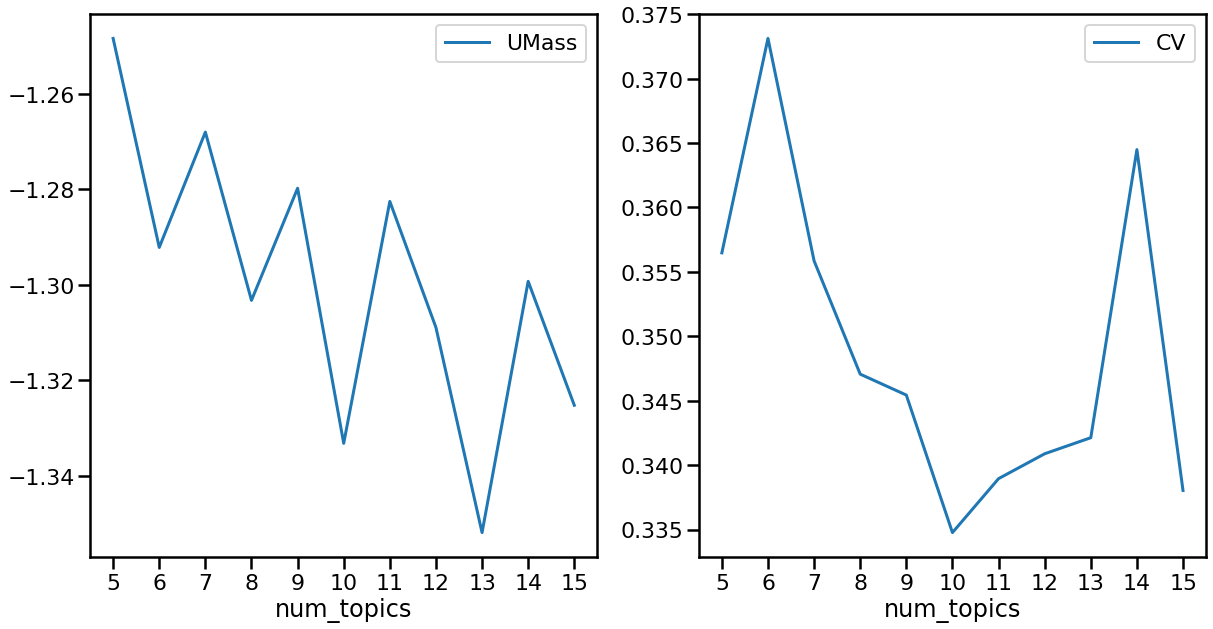

In [29]:
# Plotting it to choose the best number of topics
sns.set_context('poster') 

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));


In [ ]:
# I am choosing 11 topics as from the UMAss and CV graphs, it is where both graphs are quite high 
# (whereas before CV values were small).

num_topics = 6

# Find chunksize to make about 100 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/100
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=42)
    
print("done in {}".format(time.time()-start), flush=True)

### Language Models

In [31]:
import random


In [32]:
smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 5  

random.seed(42)

In [ ]:
# FOR USA PLOTS

# mapping the probability of a word given its history 
counts = defaultdict(lambda: defaultdict(lambda: smoothing))

# fitting the data on corpus
# corpus_lm = [line.strip().split() for line in USA_df['Plot']] 
# I am not considering the cleaned Plot since I am studying ngrams and creating language models (I need sentence connectors)

letters = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])

# collect counts for MLE
for sentence in corpus_lm:
    # include special tokens for start and the end of sentence
    tokens = [START for i in range(n_grams-1)] + sentence + [STOP]
    for letters in nltk.ngrams(tokens, n_grams):
        counts[tuple(letters[:-1])][letters[-1]] += 1
        

def sample_next_word(cond=tuple()): # to sample the next word from a given sentence
    
    keys, values = zip(*counts[cond].items()) # separate word and their counts into separate variables

    # normalize the counts into a probability distribution
    values = np.array(values)
    values /= values.sum() # create probability distribution
    
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]


def generate(initial=[],n_grams=4):
    result = [START for i in range(n_grams-1)] + initial
    for i in range((len(initial)+1)):
        try:
            next_word = sample_next_word(tuple([result[n-i] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    
    c = n_grams

    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])

NameError: name 'df' is not defined